# Install Packages
**This code predicts spatially the Abolute Dynamic Topography of the Baltic Sea using integration of autoregressive-physical model (meteorological features such as SST, Uwind, Vwind, SST) and DOY based on a MultiVariate CNN Deep Learning algorithm.**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#pd.options.plotting.backend = 'plotly'

In [2]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number].values
        target = df.iloc[(i + window), target_col_number]
        #print(features)
        #print("----")
        #print(target)
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).astype(np.float64).reshape(-1, 1)


In [7]:
import os
os.getcwd()
# cd F:/PythonCodes/Final

'c:\\Users\\saraja\\Desktop\\Submitted Version\\Code'

In [8]:
#cd 'G:/paper'
gc_df = pd.read_csv('total.csv', infer_datetime_format=True,skiprows=1)
# gc_df = pd.read_csv('Train.csv', infer_datetime_format=True)
gc_df.dropna(inplace=True)
gc_df


,DOY,SLP,Uwind,Vwind,SST,SSH
8,1,1.2715,9.2795,1.958700,5.4714,0.31793
9,1,1.2711,7.9834,1.407400,5.5952,0.38918
61,1,1.2715,9.4015,2.011700,5.5138,0.32000
62,1,1.2710,8.0667,1.473900,5.6538,0.39404
113,1,1.2716,9.7303,2.250300,5.7502,0.32646
...,...,...,...,...,...,...
3945984,365,1.2665,-2.7609,0.013072,3.3476,0.69167
3945985,365,1.2663,-2.2076,0.270130,3.4690,0.70275
3946037,365,1.2664,-2.6938,-0.126070,3.2216,0.68988
3946038,365,1.2660,-2.1865,0.172910,3.4000,0.70851


In [9]:
gc_df = gc_df[['SSH','SST','SLP','Uwind' , 'Vwind','DOY']]
gc_df.columns = ['RTDemand', 'DADemand', 'DALMP','DAEC','DACC','DAMLC']
gc_df.head(3)

,RTDemand,DADemand,DALMP,DAEC,DACC,DAMLC
8,0.31793,5.4714,1.2715,9.2795,1.9587,1
9,0.38918,5.5952,1.2711,7.9834,1.4074,1
61,0.32000,5.5138,1.2715,9.4015,2.0117,1


In [10]:
window_size = 7 # 7 days

(X, y) = window_data(gc_df, window_size, 0, 0)



y.shape

X.shape



(DADemand, _) = window_data(gc_df, window_size, 1, 1)
(DALMP, _) = window_data(gc_df, window_size, 2, 1)
(DAEC, _) = window_data(gc_df, window_size, 3, 1)
(DACC, _) = window_data(gc_df, window_size, 4, 1)
(DAMLC, _) = window_data(gc_df, window_size, 5, 1)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


DADemand = scaler.fit_transform(DADemand)
DALMP = scaler.fit_transform(DALMP)
DAEC = scaler.fit_transform(DAEC)
DACC = scaler.fit_transform(DACC)
DAMLC = scaler.fit_transform(DAMLC)


split = int(0.8 * len(X))
X_train = X[: split - 1]
X_test = X[split:]

y_train = y[: split - 1]
y_test = y[split:]

DADemand_train = DADemand[: split - 1]
DALMP_train = DALMP[: split - 1]
DAEC_train = DAEC[: split - 1]
DACC_train = DACC[: split - 1]
DAMLC_train = DAMLC[: split - 1]


DADemand_test = DADemand[split:]
DALMP_test = DALMP[split:]
DAEC_test = DAEC[split:]
DACC_test = DACC[split:]
DAMLC_test = DAMLC[split:]




X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
DADemand_train = DADemand_train.reshape((DADemand_train.shape[0], DADemand_train.shape[1], 1))
DALMP_train = DALMP_train.reshape((DALMP_train.shape[0], DALMP_train.shape[1], 1))
DAEC_train = DAEC_train.reshape((DAEC_train.shape[0], DAEC_train.shape[1], 1))
DACC_train = DACC_train.reshape((DACC_train.shape[0], DACC_train.shape[1], 1))
DAMLC_train = DAMLC_train.reshape((DAMLC_train.shape[0], DAMLC_train.shape[1], 1))
data_train = np.concatenate((X_train,
#                              db_train, dew_train,
                             DADemand_train, DALMP_train, DAEC_train, DACC_train
                             , DAMLC_train
#                              , RTLMP_train, RTEC_train, RTCC_train, RTMLC_train
                            ), axis=2)



X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
DADemand_test = DADemand_test.reshape((DADemand_test.shape[0], DADemand_test.shape[1], 1))
DALMP_test = DALMP_test.reshape((DALMP_test.shape[0], DALMP_test.shape[1], 1))
DAEC_test = DAEC_test.reshape((DAEC_test.shape[0], DAEC_test.shape[1], 1))
DACC_test = DACC_test.reshape((DACC_test.shape[0], DACC_test.shape[1], 1))
DAMLC_test = DAMLC_test.reshape((DAMLC_test.shape[0], DAMLC_test.shape[1], 1))

In [11]:
data_test = np.concatenate((X_test,
                            DADemand_test, DALMP_test, DAEC_test, DACC_test
                            ,DAMLC_test
                           ), axis=2)


X_train.shape

(640348, 7, 1)

# Conv2D
Here we create a conv2d with a filter shape of 1 timestep by fsize features, basically turning the convolution window on the Z-axis in our slides.

In [21]:
# def basic_conv2D(n_filters=10, fsize=5, window_size=5, n_features=2):
#     new_model = keras.Sequential()
#     # Hypothetically, we could also tune the padding and activation here.
#     new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
#     # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
#     new_model.add(tf.keras.layers.Flatten())
#     new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
#     new_model.add(tf.keras.layers.Dense(100))
#     new_model.add(tf.keras.layers.Dense(1))
#     new_model.compile(optimizer="adam", loss="mean_squared_error")    
#     return new_model
data_train_wide = data_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2], 1))
data_test_wide = data_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2], 1))
data_train_wide.shape

(640348, 7, 6, 1)

In [18]:
# print(data_train)

In [19]:
# m2 = basic_conv2D(n_filters=24, fsize=2, window_size=window_size, n_features=data_train_wide.shape[2])

In [ ]:
# load saved model

from keras.models import load_model
model = load_model('ST_Conv2d.h5')

In [20]:
m2=model
m2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 6, 24)          72        
                                                                 
 flatten (Flatten)           (None, 1008)              0         
                                                                 
 dense (Dense)               (None, 1000)              1009000   
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,109,273
Trainable params: 1,109,273
Non-trainable params: 0
_________________________________________________________________


In [23]:
# # m2_hist = m2.fit(data_train_wide, y_train, epochs=10)
m2_hist = m2.fit(data_train_wide, y_train, epochs=10)

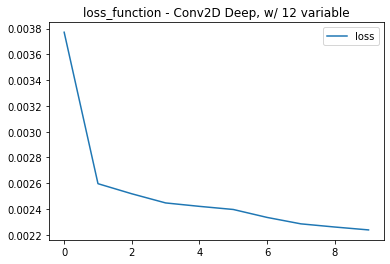

In [34]:
plt.plot(m2_hist.history["loss"])
plt.title("loss_function - Conv2D Deep, w/ 12 variable")
plt.legend(["loss"])
plt.show()

In [35]:
m2.evaluate(data_test_wide, y_test, verbose=0)

0.0022805973421782255

In [36]:
from sklearn.metrics import r2_score
predictions = m2.predict(data_test_wide)
test_r2 = r2_score(y_test, predictions)
test_r2

5003/5003 [==============================] - 11s 2ms/step


0.9105584312559938

In [37]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,0.21816,0.474035
1,0.25698,0.246772
2,0.20429,0.258457
3,0.26036,0.224847
4,0.15674,0.272733
5,0.16680,0.227830
6,0.26227,0.232267
7,0.18126,0.261867
8,0.19178,0.199052
9,0.16398,0.199012
